In [4]:
#Import der Libraries

%matplotlib inline

import sys
print('Python version:', sys.version)

import os, re, csv, codecs

import IPython
print('IPython:', IPython.__version__)

from time import time

import numpy as np
print('numpy:', np.__version__)

import scipy
print('scipy:', scipy.__version__)

import pandas as pd
print('pandas:', pd.__version__)

import matplotlib.pyplot as plt
#print('matplotlib:', plt.__version__)

import seaborn as sns
print('seaborn', sns.__version__)

import string

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Python version: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
IPython: 6.1.0
numpy: 1.13.3
scipy: 0.19.1
pandas: 0.20.3
seaborn 0.8.0


Using TensorFlow backend.


In [5]:
# Daten einlesen
data_train = pd.read_csv('D:/Projekte/Toxicity NLP/Data/train.csv')
data_test = pd.read_csv('D:/Projekte/Toxicity NLP/Data/test.csv')

# Definiere Features (X) und Labels (y)
X = data_train['comment_text']
y = data_train['toxic']

In [4]:
# Tokenization of the word corpus
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)

In [29]:
# Häufigkeit der Wörter im dictionary | Auskommentiert aufgrund der Länge
#tokenizer.word_counts

In [30]:
# Index der Wörter | Auskommentiert aufgrund der Länge
#tokenizer.word_index

Anders als bei den bisher vorgestellten klassischen ML-Modellen ist die Länge des Inputs eines neuronalen Netzes immer konstant, da sich die Anzahl der Input-Neuronen nicht ändert. Die Anzahl an Wörtern jedes Kommentars kann aber unterschiedlich sein. Daher verwendet man "padding", bei welchem jedes Kommentar auf die gleiche Länge getrimmt wird. Bei weniger Worten als maxlen wird mit Nullen aufgefüllt, bei mehr Worten als maxlen wird abgeschnitten.

Um eine geeignete Länge zu finden, kann man sich die Verteilung der Wortanzahl anschauen:

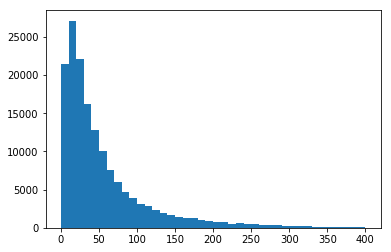

In [31]:
# Verteilung der Länge der Kommentare
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

Das Histogram zeigt, dass die meisten Kommentare etwa 30 Wörter beinhalten. Wählt man die Länge des Inputs bei 200, hat man die Verteilung großzügig abgedeckt. Mit diesem Parameter kann natürlich beliebig experimentiert werden.

In [5]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

## Building the Model

In [17]:
# Define Input Layer mit maxlen Neuronen
inp = Input(shape=(maxlen, ))

# Create Word-Embeddings
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [19]:
# Create LSTM Layer
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

In [20]:
# Reshape 3D tensor from embedding layer (None, 200, 128) into 2D tensor || Pooling Layer
x = GlobalMaxPool1D()(x)

In [21]:
# Create Dropout layer to increase Generalization and prevent overfitting
x = Dropout(0.1)(x)

In [22]:
# Create Dense Layer with ReLu activation
x = Dense(50, activation="relu")(x)

In [23]:
# Another Dropout layer
x = Dropout(0.1)(x)

In [24]:
# Create Sigmoid Layer for binary classification
x = Dense(1, activation="sigmoid")(x)

In [25]:
# Initialize the Model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Training the Model

In [26]:
# Lernparameter
batch_size = 32
epochs = 2

# Training
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 714s 5ms/step - loss: 0.1291 - acc: 0.9542 - val_loss: 0.1025 - val_acc: 0.9622
Epoch 2/2
143613/143613 [==============================] - 719s 5ms/step - loss: 0.0869 - acc: 0.9671 - val_loss: 0.1012 - val_acc: 0.9635


## Evaluation

Dieses Modell erzielt bei der binären Klassifikation "toxisch-nicht toxisch" auf Anhieb respektable Ergebnisse und schlägt die klassischen Ansätze im Bezug auf die Accuracy. Zum Vergleich: der Voting-Classifier der Ensemble Methoden erzielte 95,40% Accuracy.

In [27]:
# Zusammenfassung des Modells
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

# Modell mit allen Klassen

Nachfolgend wird das gleiche LSTM Modell mit allen sechs Klassen ausgeführt um der ursprünglichen Aufgabe zu entsprechen. Dazu werden alle Klassen im Output y festgehalten und der Output Layer auf 6 Neuronen erhöht (One-hot).

In [6]:
# Hinzufügen der Klassen
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data_train[list_classes].values

In [7]:
# Define Input Layer mit maxlen Neuronen
inp = Input(shape=(maxlen, ))

# Create Word-Embeddings
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# Create LSTM Layer
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

# Reshape 3D tensor from embedding layer (None, 200, 128) into 2D tensor || Pooling Layer
x = GlobalMaxPool1D()(x)

# Create Dropout layer to increase Generalization and prevent overfitting
x = Dropout(0.1)(x)

# Create Dense Layer with ReLu activation
x = Dense(50, activation="relu")(x)

# Another Dropout layer
x = Dropout(0.1)(x)

# Create Sigmoid Layer for binary classification
x = Dense(6, activation="sigmoid")(x)

# Initialize the Model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Lernparameter
batch_size = 32
epochs = 2

# Training
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 689s 5ms/step - loss: 0.0682 - acc: 0.9776 - val_loss: 0.0501 - val_acc: 0.9818
Epoch 2/2
143613/143613 [==============================] - 686s 5ms/step - loss: 0.0446 - acc: 0.9833 - val_loss: 0.0461 - val_acc: 0.9827


### Vergleich mit Multiclass LR

In [28]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics, ensemble
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.model_selection as ms

clf_lr = Pipeline([('vect', CountVectorizer(token_pattern='[a-zA-Z\'][a-zA-Z\']+', stop_words='english')),
                    ('clf', LogisticRegression(C=10, random_state=1))
                    ])

scores = []
for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    y = data_train[label]
    cv_score = np.mean(ms.cross_val_score(clf_lr, X, y, cv=3, scoring='roc_auc'))
    scores.append(cv_score)
    print(f'CV score for class {label} is {cv_score}')
    
    
print(f'Total CV score is {np.mean(scores)}')

CV score for class toxic is 0.9509036278482083
CV score for class severe_toxic is 0.9561873950478931
CV score for class obscene is 0.9608835153632063
CV score for class threat is 0.9520976080671062
CV score for class insult is 0.9429496486501124
CV score for class identity_hate is 0.9126526299428998
Total CV score is 0.9459457374865711


Auch hier schneidet das LSTM Netz deutlich besser ab, als die Multiclass LR. 

# Ergänzungen zum Modell

### Feature Engineering mit Verhältnis der Großbuchstaben im Kommentar

In [8]:
# Ausbau der Daten mit zusätzlichen Features Länge des Kommentars, Anzahl an Großbuchstaben und Großbuchstaben/Länge
data_train['total_length'] = data_train['comment_text'].apply(len)
data_train['capitals'] = data_train['comment_text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
data_train['caps_ratio'] = data_train.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)

In [9]:
# Hinzufügen des Features zum Inputarray
data_array = np.array(data_train['caps_ratio'])
X_t_extended = np.hstack((X_t, np.atleast_2d(data_array).T))

In [10]:
# Hinzufügen der Klassen
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = data_train[list_classes].values

# Define Input Layer mit maxlen Neuronen
inp = Input(shape=(201, ))

# Create Word-Embeddings
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

# Create LSTM Layer
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)

# Reshape 3D tensor from embedding layer (None, 200, 128) into 2D tensor || Pooling Layer
x = GlobalMaxPool1D()(x)

# Create Dropout layer to increase Generalization and prevent overfitting
x = Dropout(0.1)(x)

# Create Dense Layer with ReLu activation
x = Dense(50, activation="relu")(x)

# Another Dropout layer
x = Dropout(0.1)(x)

# Create Sigmoid Layer for binary classification
x = Dense(6, activation="sigmoid")(x)

# Initialize the Model
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Lernparameter
batch_size = 32
epochs = 2

# Training
model.fit(X_t_extended, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 699s 5ms/step - loss: 0.0677 - acc: 0.9781 - val_loss: 0.0494 - val_acc: 0.9819
Epoch 2/2
143613/143613 [==============================] - 696s 5ms/step - loss: 0.0446 - acc: 0.9835 - val_loss: 0.0465 - val_acc: 0.9829


Die Verbesserung ist leider nur unerheblich und könnte wohl genauso gut zufällig sein. Die Vermutung liegt nahe, dass ein zusätzliches Feature bei 200 Inputs nicht allzu stark ins Gewicht fällt.

# Quellen

https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras

https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/